#### **Check GPU**

In [1]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Display GPU name
!nvidia-smi

Num GPUs Available: 1
Tue Feb 18 14:17:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------

#### **Configure Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to your dataset
import os
os.chdir('/content/drive/MyDrive/Severstal/severstal-1000/')  # Change this path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import json

!pip install keras keras.layers
import cv2
import keras
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from glob import glob

%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
import gc
!pip install segmentation-models
!pip install git+https://github.com/qubvel/segmentation_models

ERROR: Could not find a version that satisfies the requirement keras.layers (from versions: none)
ERROR: No matching distribution found for keras.layers
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-f_nswe_8
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-f_nswe_8
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.0.0
    Uninstalling efficientnet-1.0.0:
      Successfully uninstalled efficientnet-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [8]:
trainImgPath = "/content/drive/MyDrive/Severstal/severstal-1000/train_images/"
trainCsv = "/content/drive/MyDrive/Severstal/severstal-1000/train.csv"
data=pd.read_csv(trainCsv)
data.ClassId=data.ClassId.astype(int)

train_Img_Id = []
train_class_Id = []
for i in os.listdir(trainImgPath):
    for j in range(1,5):
        train_Img_Id.append(i)
        train_class_Id.append(j)
train_Imgs = pd.DataFrame({'ImageId':train_Img_Id,'ClassId':train_class_Id})
train_Imgs.head(10)



train_data = pd.merge(train_Imgs,data ,how='outer', on=['ImageId','ClassId'])
train_data = train_data.fillna('')
train_data

,ImageId,ClassId,EncodedPixels
0,0007a71bf.jpg,1,
1,0007a71bf.jpg,2,
2,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
3,0007a71bf.jpg,4,
4,0025bde0c.jpg,1,
...,...,...,...
3995,ffcf72ecf.jpg,4,
3996,ffffd67df.jpg,1,
3997,ffffd67df.jpg,2,
3998,ffffd67df.jpg,3,30931 43 31103 127 31275 211 31489 253 31745 2...


In [9]:
train_data = pd.pivot_table(train_data, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index() # add Index column to one level with classID
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
has_defect = []
for index,row in train_data.iterrows():
    if row.Defect_1:# or row.Defect_2 or row.Defect_3 or row.Defect_4:
        has_defect.append(1)
    else:
        has_defect.append(0)

train_data["has_defect"] = has_defect

train_data.head(5)

<ipython-input-9-e6aca2edab14>:1: FutureWarning: The provided callable <function sum at 0x79be3b724a40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  train_data = pd.pivot_table(train_data, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)


,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,has_defect
0,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,0
1,0025bde0c.jpg,,,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...,0
2,005f19695.jpg,,,123137 7 123393 19 123649 32 123905 44 124161 ...,,0
3,0088260da.jpg,,,26044 13 26283 40 26522 67 26762 92 27001 119 ...,,0
4,00af2671f.jpg,,,155585 64 155713 5542 161281 179 161537 128 16...,,0


In [10]:
WIDTH=288
HEIGHT=288
TRAINING_SIZE=7095

x_train, x_test = train_test_split(train_data, test_size = 0.1, random_state=42)
x_train, x_val = train_test_split(x_train, test_size = 0.2, random_state=42)
print(x_train.shape, x_val.shape, x_test.shape)

(720, 6) (180, 6) (100, 6)


In [11]:
x_train_classification = x_train[['ImageId','has_defect']]
x_val_classification = x_val[['ImageId','has_defect']]
x_test_classification = x_test[['ImageId','has_defect']]
print(x_train_classification.shape , x_val_classification.shape,x_test_classification.shape)
x_train_classification.head()

(720, 2) (180, 2) (100, 2)


,ImageId,has_defect
528,8aa3af3da.jpg,0
278,4c6110948.jpg,0
394,6812ce51c.jpg,0
258,477a186bc.jpg,0
926,edbb46a8e.jpg,0


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                           width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_dataframe(
        dataframe=x_train_classification.astype(str),
        directory=trainImgPath,
        x_col="ImageId",
        y_col="has_defect",
        target_size=(WIDTH,HEIGHT),
        batch_size=16,
        class_mode='binary')

valid_data_generator = test_datagen.flow_from_dataframe(
        dataframe=x_val_classification.astype(str),
        directory=trainImgPath,
        x_col="ImageId",
        y_col="has_defect",
        target_size=(WIDTH,HEIGHT),
        batch_size=16,
        class_mode='binary')

Found 720 validated image filenames belonging to 2 classes.
Found 180 validated image filenames belonging to 2 classes.


#### **Classification Model**

In [13]:
classification_model = keras.applications.xception.Xception(include_top = False, input_shape = (HEIGHT,WIDTH,3))

layer = classification_model.output
layer = GlobalAveragePooling2D()(layer)

layer = Dense(1024, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)

layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)

layer = Dense(64, activation='relu')(layer)
predictions = Dense(1, activation='sigmoid')(layer)
model = Model(inputs=classification_model.input, outputs=predictions)
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 288, 288, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 143, 143, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 143, 143, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 143, 143, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 141, 141, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 141, 141, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 141, 141, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 141, 141, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 141, 141, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 141, 141, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 141, 141, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 141, 141, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 71, 71, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 71, 71, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 23,523,497 (89.74 MB)

 Trainable params: 23,465,897 (89.52 MB)

 Non-trainable params: 57,600 (225.00 KB)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
Training = model.fit(train_data_generator, validation_data = valid_data_generator, epochs = 10, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 733ms/step - accuracy: 0.7663 - loss: 0.5719 - val_accuracy: 0.8556 - val_loss: 0.4727
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 581ms/step - accuracy: 0.7974 - loss: 0.4875 - val_accuracy: 0.8556 - val_loss: 0.4369
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 608ms/step - accuracy: 0.8795 - loss: 0.3527 - val_accuracy: 0.8556 - val_loss: 0.4114
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 588ms/step - accuracy: 0.8749 - loss: 0.3642 - val_accuracy: 0.5111 - val_loss: 0.9133
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 580ms/step - accuracy: 0.8718 - loss: 0.3173 - val_accuracy: 0.3667 - val_loss: 1.7867
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 593ms/step - accuracy: 0.8836 - loss: 0.2836 - val_accuracy: 0.6222 - val_loss: 2.2870
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 593ms/step - accuracy: 0.8668 - loss: 0.3349 - val_accuracy: 0.8611 - val_loss: 0.7380
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 570ms/step - accuracy: 0.8750 - loss: 0.3068 - val_acc

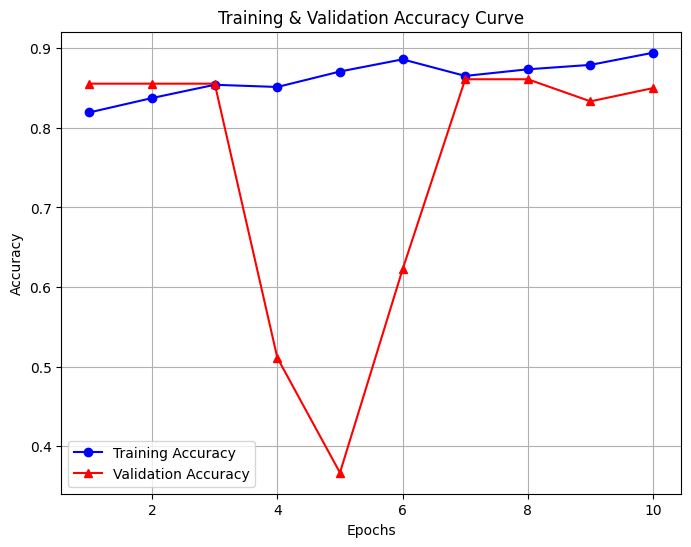

In [15]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_acc = Training.history['accuracy']
val_acc = Training.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # 'bo-' means blue circle markers with line
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')  # 'r^-' means red triangle markers with line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
model.save('/content/drive/MyDrive/Severstal/severstal-1000/classification_model_class1.keras')